In [1]:
#==========================#
# Import relevant packages #
#==========================#


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erfinv
from iminuit import Minuit
from scipy.stats import chi2
from scipy.stats import binom
%matplotlib inline
from scipy.stats import poisson

# Report 1 - Estimating Parameters with MC Generated Samples

## Description

The report based around a particle decay of $X \rightarrow D$, and a parameter related to the matter/anti-matter asymmetry of the Universe will be measured.

The PDF of the relevant particle decay is described by:
$$
P(t;\tau,\Delta m_s, V) \propto (1+V\sin{(\Delta mt)}) \times \exp{-\frac{t}{\tau}}
$$
where

* $t$ is the observable quantity - the decay time of each decay.
* $\tau$ is a lifetime parameter.
* $\Delta m$ is a mass difference parameter which leads to sinusoidal oscillations superimposed on the exponential decay.
* $V$ is a parameter which measures matter/anti-matter asymmetry and has the value zero if
the universe is symmetric.

And the nominal value of the parameters are:

* $\tau = 1.5$
* $\Delta m = 20.0$
* $V = 0.1$

We will first plot the PDF to see the distribution within the range 0 to 10. At this stage, something else in addition is to vary the parameters a little to see how change of each parameter affects our PDF distribution.

In [2]:
#==================================================#
# Create a function returning the PDF distribution #
#==================================================#

def pdf_distribution(t, tau, delta_m, V):
    return ( (1 + V*np.sin(delta_m*t))*np.exp(-t/tau) )

In [3]:
#=====================================================#
# Define parameters for plotting the PDF distribution #
#=====================================================#

loBound = 0.
hiBound = 10.
n_interval = 1000
t = np.linspace(loBound, hiBound, n_interval, endpoint=True)
# nominal values for the parameters
tau1 = 1.5
delta_m1 = 20.
v1 = 0.1
# Three more sets of parameters to see how our PDF distribution change
tau2 = 3.
delta_m2 = 10.
v2 = 1.

tau3 = 2.
delta_m3 = 10.
v3 = 4.

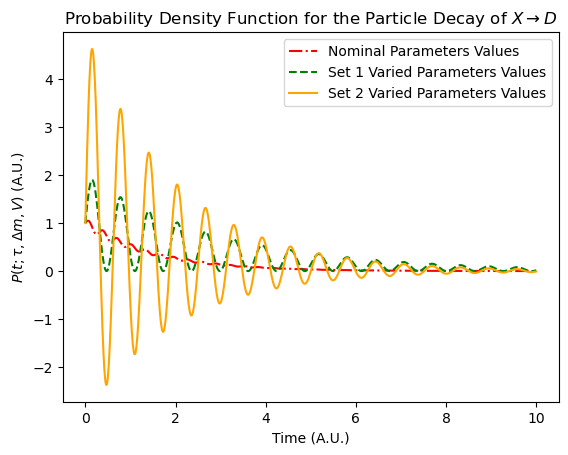

In [4]:
#===========================#
# Plot the PDF distribution #
#===========================#

plt.plot(t, pdf_distribution(t, tau1, delta_m1, v1), ls='-.', color='r', label='Nominal Parameters Values')
plt.plot(t, pdf_distribution(t, tau2, delta_m2, v2), ls='--', color='g', label='Set 1 Varied Parameters Values')
plt.plot(t, pdf_distribution(t, tau3, delta_m3, v3), color='orange', label='Set 2 Varied Parameters Values')
plt.title(r'Probability Density Function for the Particle Decay of $X \rightarrow D$')
plt.xlabel('Time (A.U.)')
plt.ylabel(r'$P(t;\tau,\Delta m, V)$ (A.U.)')
plt.legend()
plt.show()

The above plot shows the distribution of our PDF that characterizes the particle decay, and three of them have different parameters, this is to show how the parameters change the waveform of our PDF distribution.

As seen from above, and equation from the top description section. It appears that the function is decaying in a sinusoidal way. And the parameters ($\tau, \Delta m, V$) represents  the decay constant, the angular frequency and the amplitude, respectively.

## Question 1

In this question, we'll use toy Monte Carlo event generation to simulate multiple pseudo-experiments, and use this method to determine the expected statistical precision with which one could measure each of the parameters with 10000 events.

The first step here is to create a PDF class which generates random points based on the PDF function given in the description for the relevant particle decay, and also contain methods/functions in setting different parameters.

In [5]:
#==============================================================================================#
# Create a PDF class used to model the oscillatory exponential decay pdf function as described #
#==============================================================================================#

class DecayPDF(object):

    # Constructor
    def __init__(self, loBound, hiBound, tau, delta_m, V):
        self.loBound = loBound
        self.hiBound = hiBound
        self.tau = tau
        self.delta_m = delta_m
        self.V = V
    
        # initialize distribution mass array
        self.mass = []

        # find the min and max
        self.minVal = self.find_min()
        self.maxVal = self.find_max()

    
    #———————————————————————————————————————————#
    # Function used to find maximum of function #
    #———————————————————————————————————————————#

    def find_max(self):
        # First generate a grid of x points
        x = np.linspace(self.loBound, self.hiBound, endpoint=True, num=100000)
        # Next, evaluate the function at all the x, and return the maximum
        y = self.evaluate(x)
        return y.max()

    
    #———————————————————————————————————————————#
    # Function used to find minimum of function #
    #———————————————————————————————————————————#

    def find_min(self):
        # First generate a grid of x points
        x = np.linspace(self.loBound, self.hiBound, endpoint=True, num=100000)
        # Next, evaluate the function at all the x, and return the minimum
        y = self.evaluate(x)
        return y.min()


    #————————————————————————————————————————————————#
    # Function used to set passed vars as parameters #
    #————————————————————————————————————————————————#

    def setParameters(self, tau, delta_m, V):
        self.tau = tau
        self.delta_m = delta_m
        self.V = V


    #————————————————————————————————————————————————#
    # Evaluate the PDF and return un-normalized vals #
    #————————————————————————————————————————————————#

    def evaluate(self, t):
        return ( (1+self.V*np.sin(self.delta_m*t))*np.exp(-t/self.tau) )

    
    #—————————————————————————————————————————————————————————————————————————————————————————————#
    # From the PDF distribution for our decay, sample random points (here using the 'box' method, #
    # which this technique uses the generation of two random numbers, starting from anuniform     #
    # random number generator. Consider the algorithm equivalent to generating random numbers     #
    # in a “box”. Then only keeping those which fall under the curve.                             #
    #—————————————————————————————————————————————————————————————————————————————————————————————#

    def next(self):
        doLoop = True
        while (doLoop):
            x = np.random.uniform(self.loBound, self.hiBound)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(0, self.maxVal)
            # now consider the acceptance if y1 is above x-axis
            if (y2<y1):
                filtered_x = x
                self.mass.append(x)
                return filtered_x


    #———————————————————————————————————————————#
    # Function which returns the mass attribute #
    #———————————————————————————————————————————#

    def returnMass(self):
        return np.array(self.mass)


    #——————————————————————————————————————#
    # Function which clears the mass array #
    #——————————————————————————————————————#

    def flushMass(self):
        self.mass.clear()


    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound, limit=150)
        return integral_result

Now let's first generate a toy dataset with the PDF class we wrote in the cell above, and make a histogram for this dataset to test that our PDF class is running and working.

In [6]:
# Nominal parameter values
tau_nom = 1.5
delta_m_nom = 20.
V_nom = 0.1

# Initialize the PDF class and feed in the nominal parameters
pdf = DecayPDF(loBound, hiBound, tau_nom, delta_m_nom, V_nom)

# Generate 10000 events for this first test toy dataset
nEvents = 10000
for i in range(nEvents):
    pdf.next()

# Return the mass array and flush them so that it resets and the class can be used again for generating new toy datasets
evts = pdf.returnMass()
pdf.flushMass()

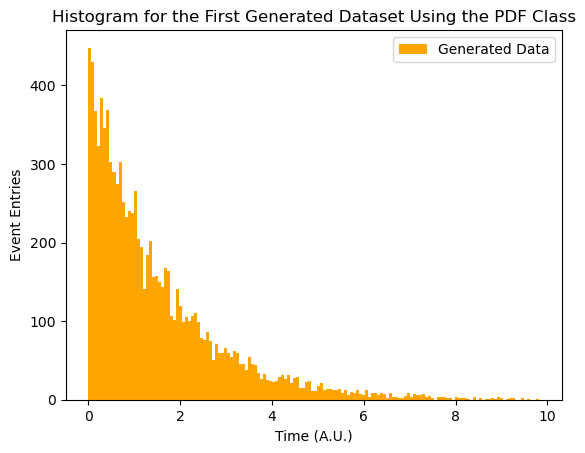

In [7]:
# plot our first generated dataset with our pdf class
plt.hist(evts, 150, color='orange', label='Generated Data')
plt.title('Histogram for the First Generated Dataset Using the PDF Class')
plt.xlabel('Time (A.U.)')
plt.ylabel('Event Entries')
plt.legend()
plt.show()

Looking at the above, our first generated dataset appears to be sensible, following the general trend of the pdf function as we expect. Next, we would like to use a maximum likelihood fit to determine the precision expected for each of the parameters $\tau$,$\Delta m$ and $V$. In order to do this, 100 generated toy datasets need to be fitted.

First, we will write a maximum likelihood fit class for this, using the negative of the log of the joint likelihood. Then we will fit using the class below on the 1 generated dataset above to see whether our class works well or not.


In [8]:
#==========================================================================================#
# Create class for negative log-likelihood minimization statistic used for fitting the pdf #
#==========================================================================================#

class NegativeLLcalculator(object):
    
    def __init__(self, pdf, data):
        self.pdf = pdf
        self.data = data


    # function used to update data, mainly for the ability to recycle this class for different fit pdfs
    def updateData(self, data):
        self.data = data

    # Function used to calculate log likelihood
    def calc_neg_LL(self):
        likelihood = self.pdf.evaluate(self.data)/(self.pdf.integrate(self.pdf.loBound, self.pdf.hiBound))
        # set any negative likelihoods to close to 0 (negligible)
        if (likelihood <= 0).any():
            likelihood[likelihood <=0 ] = 1e-10
        log_likelihood = np.log(likelihood)
        return -log_likelihood.sum()

    # To calcualte an NLL for our pdf
    def evaluate(self, tau, delta_m, V):
        nll = 0.
        self.pdf.setParameters(tau, delta_m, V)
        # here, compute the log likelyhood
        return self.calc_neg_LL()

Now we will use iMinuit to fit our dataset with the minimization statistics written above.

In [9]:
# Define fit parameters in a dictionary
init_params = {
        'tau':                  1.5,
        'delta_m':              20.,
        'V':                    0.1,
}

# First initialize the pdf classes for function we use to fit, and the fitting statistics
pdf = DecayPDF(loBound, hiBound, **init_params)
fit_stats = NegativeLLcalculator(pdf, evts)

# Initialize iminuit minimizer
minimizer = Minuit(fit_stats.evaluate, **init_params)

# Set the error difference to 0.5 (we are using NegativeLL)
minimizer.errordef = 0.5

# Fit for best parameters
mresult = minimizer.migrad()
mresult

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.399e+04                  │              Nfcn = 42               │
│ EDM = 2.55e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.514   │   0.016   │            │            │         │         │       │
│ 1 │ delta_m │   19.92   │   0.07    │            │            │         │         │       │
│ 2 │ V       │   0.094   │   0.014   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │      tau  delta_m        V │
├─────────┼────────────────────────────┤
│     tau │ 0.000244        0  0.01e-3 │
│ delta_m │        0  0.00475       -0 │
│       V │  0.01e-3       -0 0.000201 │
└─────────┴────────────────────────────┘

The results for the Minuit minimizer is shown, with the fitted parameters for this 1 dataset as following:
* $\tau = 1.514 \pm 0.016$ (A.U.)
* $\Delta m = 19.92 \pm 0.07$ (A.U.)
* $ V = 0.094 \pm 0.014$ (A.U.)

Now, with the idea that we can have somewhat of a good fit on the parameters, now we would like to determine the expected precision on these fitted parameters. This is gonna be done by generating 100 toy datasets, each containing 10000 events like the dataset we generated above, and we will fit each one of them, store the fitted values and then obtain the precision and show the results.

First thing here is to start by creating a function which will be used to generate and fit datasets, and then store these fitted parameter values.

In [10]:
def generate_fit_data(loBound, hiBound, nominal_params):
    # define a dictionary containing initial guess of params
    initial_params = {
        'tau'      : 1.1,
        'delta_m'  : 20.4,
        'V'        : 0.11,
    }

    # initialize pdf 
    pdf = DecayPDF(loBound, hiBound, *nominal_params.values())

    # Generate event in a loop (same as before)
    for i in range(nEvents):
        pdf.next()
    
    # Return the mass array and flush them so that it resets and the class can be used again for generating new toy datasets
    evts = pdf.returnMass()
    pdf.flushMass()

    # Now initialize the maximum likelyhood minimizing statistics
    fit_statistics = NegativeLLcalculator(pdf, evts)
    minuit_minimizer = Minuit(fit_statistics.evaluate, **initial_params)
    results = minuit_minimizer.migrad()

    # Now store the parameter values
    params_vals = []
    for i in initial_params.keys():
        params_vals.append(results.params[i].value)
    return params_vals    

Now with the above function, let's loop over 100 times to generate 100 toy dataset and fit them, each with 10000 events, and obtaining their optimized parameter values.

In [11]:
# Define parameters again for completeness purpose
nominal_params_vals = {
    'tau'           : 1.5,
    'delta_m'       : 20.,
    'V'             : 0.1,
}

# Define a dictionary with empty lists for holding optimized params values
optimized_params_val_dict = {
    'tau_optim'           : [],
    'delta_m_optim'       : [],
    'V_optim'             : [],
}

# Now generate and fit 100 toy datasets
n_toy_datasets = 100
for i in range(n_toy_datasets):
    # Use our function for generating and fitting dataset
    optim_params_vals = generate_fit_data(loBound, hiBound, nominal_params_vals)

    # Then append the returned optimized parameter values to our dictionary
    for idx, key in enumerate(optimized_params_val_dict):
        optimized_params_val_dict[key].append(optim_params_vals[idx])

# Now our dict should contain the optimized parameters, now convert each list into np.array
for key in optimized_params_val_dict:
    optimized_params_val_dict[key] = np.array(optimized_params_val_dict[key])

With our optimized parameters from 100 toy datasets, the precision of our parameters can be calculated by taking the mean values of each list in the dictionary.

In [12]:
# Calculate the precision of our parameters
tau_precision = optimized_params_val_dict['tau_optim'].mean()
delta_m_precision = optimized_params_val_dict['delta_m_optim'].mean()
V_precision = optimized_params_val_dict['V_optim'].mean()

print('The tau parameter precision for our MC generated simulation is %.3f (A.U.).' % tau_precision)
print('The delta m parameter precision for our MC generated simulation is %.3f (A.U.).' % delta_m_precision)
print('The V parameter precision for our MC generated simulation is %.3f (A.U.).' % V_precision)

The tau parameter precision for our MC generated simulation is 1.498 (A.U.).
The delta m parameter precision for our MC generated simulation is 18.826 (A.U.).
The V parameter precision for our MC generated simulation is 0.085 (A.U.).


Now, with the precision of our parameters explored and calculated, we would like to take a look at the bias for our parameters. The way we look at the bias here is by defining it to be the difference between the optimized parameter precision and the nominal truth parameter values.

In [13]:
# calculate the bias on the parameters and print them
tau_bias = abs(nominal_params_vals['tau'] - tau_precision)
delta_m_bias = abs(nominal_params_vals['delta_m'] - delta_m_precision)
V_bias = abs(nominal_params_vals['V'] - V_precision)

print('The tau parameter bias for our MC generated simulation is %.3f (A.U.).' % tau_bias)
print('The delta m parameter bias for our MC generated simulation is %.3f (A.U.).' % delta_m_bias)
print('The V parameter bias for our MC generated simulation is %.3f (A.U.).' % V_bias)

The tau parameter bias for our MC generated simulation is 0.002 (A.U.).
The delta m parameter bias for our MC generated simulation is 1.174 (A.U.).
The V parameter bias for our MC generated simulation is 0.015 (A.U.).


Next we need to calculate and assess the bias on the bias we calculated above for our optimized precision. This arose from the fact that our dataset is drawn from a Gaussian distribution, which, now, we can use the standard error on the mean to compute the bias on our error.
$$
\delta \sigma = \frac{\sigma}{\sqrt{N}}
$$
where N is the number of optimized parameters

In [14]:
tau_error = optimized_params_val_dict['tau_optim'].mean()/np.sqrt(n_toy_datasets)
delta_m_error = optimized_params_val_dict['delta_m_optim'].mean()/np.sqrt(n_toy_datasets)
V_error = optimized_params_val_dict['V_optim'].mean()/np.sqrt(n_toy_datasets)

print('From 100 toy dataset, the precision and bias on the bias of the tau parameter is %.3f\u00b1%.3f (A.U.)'\
      % (tau_precision, tau_error))
print('From 100 toy dataset, the precision and bias on the bias of the delta m parameter is %.3f\u00b1%.3f (A.U.)'\
      % (delta_m_precision, delta_m_error))
print('From 100 toy dataset, the precision and bias on the bias of the V parameter is %.3f\u00b1%.3f (A.U.)'\
      % (V_precision, V_error))

From 100 toy dataset, the precision and bias on the bias of the tau parameter is 1.498±0.150 (A.U.)
From 100 toy dataset, the precision and bias on the bias of the delta m parameter is 18.826±1.883 (A.U.)
From 100 toy dataset, the precision and bias on the bias of the V parameter is 0.085±0.009 (A.U.)


# Question 2

In question 2, we hypothesize that the data has a additional background that will be an exponential with a much longer lifetime: it is 8 units (compared to 1.5 for the signal).

We first create a class called exponential that'll be used to model background exponential.

In [15]:
#=========================================================================#
# Create an Exponential class (used to model the background distribution) #
#=========================================================================#


class Exponential(object):
    
    # Constructor
    def __init__(self, loBound, hiBound, decayConst):
        self.loBound = loBound
        self.hiBound = hiBound
        self.decayConst = decayConst
        self.max = self.find_max()

        # create an array for holding mass values
        self.mass = []
    
    # Set parameters
    def setParameters(self, decayConst):
        self.decayConst = decayConst
    

    # Function used to find maximum of function
    def find_max(self):
        # First generate a grid of x points
        x = np.linspace(self.loBound, self.hiBound, endpoint=True, num=100000)
        # Next, evaluate the function at all the x, and return the maximum
        y = self.evaluate(x)
        return y.max()
    

    # Returns max value of function
    def maxVal(self) :
        return self.max

    # Evaluate method (normalized)
    def evaluate(self, t):
        part1 = np.exp(-t/self.decayConst)
        norm1 = self.decayConst*(1-np.exp(-self.hiBound/self.decayConst))
        return part1/norm1 
    
    # Create a function that generates a single point using the box method
    def next(self):
        x = np.random.exponential(self.decayConst)
        self.mass.append(x)
        return x

Now, with the creation of the exponential class, proceed to produce a PDF class that contains the signal and the background, while the signal is the same pdf we used in question 1, and the bkg being the exponential.

In [16]:
#=========================================================================#
# Create a class which will return the sum of the signal and background   #
# distributions weighted by the fractions of signal and background events #
#=========================================================================#

class SignalWithBackground(object):
    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, loBound, highBound, bkgFraction, tau, delta_m, V, decayConst):
        
        self.loBound = loBound
        self.highBound = highBound
        self.bkgFraction = bkgFraction

        self.mass = []

        # initialize pdf objects
        self.signal = DecayPDF(loBound, hiBound, tau, delta_m, V)
        self.bkg = Exponential(loBound, hiBound, decayConst)


    #——————————————————————————————————————————————————————#
    # A function for setting passed vars as pdf parameters #
    #——————————————————————————————————————————————————————#

    def setParameters(self, bkgFraction, tau, delta_m, V, decayConst):
        self.bkg.decayConst = decayConst
        self.bkgFraction  = bkgFraction
        self.signal.tau = tau
        self.signal.delta_m = delta_m
        self.signal.V = V
        self.decayConst = decayConst


    #———————————————————#
    # Evaluation method #
    #———————————————————#

    def evaluate(self, x):
        return (1-self.bkgFraction)*self.signal.evaluate(x)/self.signal.integrate(self.loBound, self.highBound)\
              + self.bkgFraction*self.bkg.evaluate(x)
    

    #—————————————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using np.random.normal  #
    # method, generated var is returned and appended to the mass list     #
    #—————————————————————————————————————————————————————————————————————#

    def next(self):
        
        q = np.random.uniform()
        if (q<self.bkgFraction):
            # if here, we will draw x from bkg distribution
            filtered_x = self.bkg.next()
        else:
            # if here, we will draw x from signal distribution
            filtered_x = self.signal.next()

        self.mass.append(filtered_x)
        return filtered_x


    #———————————————————————————————————————————#
    # Function which returns the mass attribute #
    #———————————————————————————————————————————#

    def returnMass(self):
        return np.array(self.mass)


    #——————————————————————————————————————#
    # Function which clears the mass array #
    #——————————————————————————————————————#

    def flushMass(self):
        self.mass.clear()

First, generate 5 datasets (each set being 10000 events), each with a different exponential back-
ground fraction (with a lifetime of 8) added to the signal. The fractions will be:
* Background Fraction 1 = 0
* Background Fraction 2 = 0.1
* Background Fraction 3 = 0.2
* Background Fraction 4 = 0.3
* Background Fraction 5 = 0.4


P.S.: This section below would've been done by using dict to hold 5 datasets and loop over them for operation and plotting, but due to bugs regarding dict operations for storing and extracting, the datasets didn't seem to all successfully save to the dict, hence, the brute-forced approach on manually creating and plotting and fitting each dataset.

Apparently this is highly not recommended if there are more dataset as in real-life examples, due to the inefficiency and unpracticality of this type of code implementation. But in the case for this report, this can be done as we have 5 datasets and this is treated as an ad-hoc fix.

In [17]:
# define the parameters
nEvts = 10000
# in our nominal parameter dict, add another for the exponential decayConst
nominal_params_vals['decayConst'] = 8.
# define background fraction values for 5 datasets
bkgFraction_vals = [0., 0.1, 0.2, 0.3, 0.4]

In [18]:
# initialize pdf class for SignalWithBkg pdf, 0 for bkg fraction
pdf_expBkg0 = SignalWithBackground(loBound, hiBound, bkgFraction_vals[0], \
                                  nominal_params_vals['tau'], nominal_params_vals['delta_m'], \
                                  nominal_params_vals['V'], nominal_params_vals['decayConst'])
   
# Generate the dataset for the current bkg fraction
for i in range(nEvts):
    pdf_expBkg0.next()

# save the dataset
dataset0 = pdf_expBkg0.returnMass()
pdf_expBkg0.flushMass()

In [19]:
# initialize pdf class for SignalWithBkg pdf, 0.1 for bkg fraction

pdf_expBkg1 = SignalWithBackground(loBound, hiBound, bkgFraction_vals[1], nominal_params_vals['tau'], nominal_params_vals['delta_m'], \
                                  nominal_params_vals['V'], nominal_params_vals['decayConst'])
   
# Generate the dataset for the current bkg fraction
for i in range(nEvts):
    pdf_expBkg1.next()

# save the dataset
dataset1 = pdf_expBkg1.returnMass()
pdf_expBkg1.flushMass()

In [20]:
# initialize pdf class for SignalWithBkg pdf, 0.2 for bkg fraction

pdf_expBkg2 = SignalWithBackground(loBound, hiBound, bkgFraction_vals[2], nominal_params_vals['tau'], nominal_params_vals['delta_m'], \
                                  nominal_params_vals['V'], nominal_params_vals['decayConst'])
   
# Generate the dataset for the current bkg fraction
for i in range(nEvts):
    pdf_expBkg2.next()

# save the dataset
dataset2 = pdf_expBkg2.returnMass()
pdf_expBkg2.flushMass()

In [21]:
# initialize pdf class for SignalWithBkg pdf, 0.3 for bkg fraction

pdf_expBkg3 = SignalWithBackground(loBound, hiBound, bkgFraction_vals[3], nominal_params_vals['tau'], nominal_params_vals['delta_m'], \
                                  nominal_params_vals['V'], nominal_params_vals['decayConst'])
   
# Generate the dataset for the current bkg fraction
for i in range(nEvts):
    pdf_expBkg3.next()

# save the dataset
dataset3 = pdf_expBkg3.returnMass()
pdf_expBkg3.flushMass()

In [22]:
# initialize pdf class for SignalWithBkg pdf, 0.2 for bkg fraction

pdf_expBkg4 = SignalWithBackground(loBound, hiBound, bkgFraction_vals[4], nominal_params_vals['tau'], nominal_params_vals['delta_m'], \
                                  nominal_params_vals['V'], nominal_params_vals['decayConst'])
   
# Generate the dataset for the current bkg fraction
for i in range(nEvts):
    pdf_expBkg4.next()

# save the dataset
dataset4 = pdf_expBkg4.returnMass()
pdf_expBkg4.flushMass()

Now, let's plot all 5 datasets into histogram to see the difference with varying background fractions.

In [23]:
# Define colors for each plot
colors = ['blue', 'green', 'red', 'gray', 'paleturquoise']

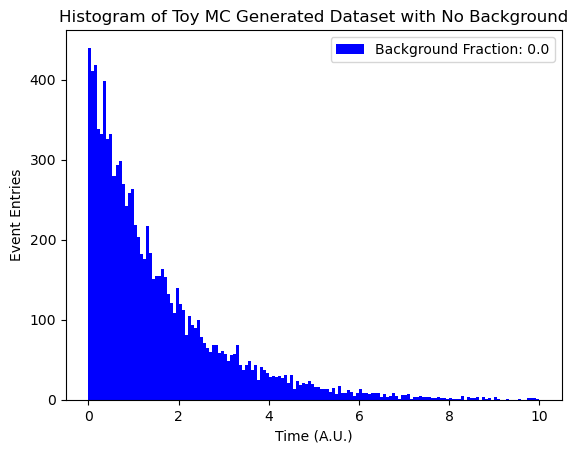

In [24]:
plt.hist(dataset0, 150, color=colors[0],\
         label='Background Fraction: %s' % bkgFraction_vals[0], range=(0.0, 10.0))
plt.xlabel('Time (A.U.)')
plt.ylabel('Event Entries')
plt.title('Histogram of Toy MC Generated Dataset with No Background')
plt.legend()
plt.show()

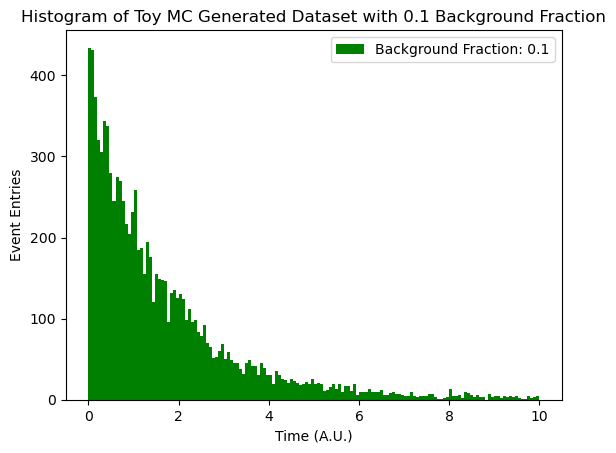

In [25]:
plt.hist(dataset1, 150, color=colors[1],\
         label='Background Fraction: %s' % bkgFraction_vals[1], range=(0., 10.))
plt.xlabel('Time (A.U.)')
plt.ylabel('Event Entries')
plt.title('Histogram of Toy MC Generated Dataset with 0.1 Background Fraction')
plt.legend()
plt.show()

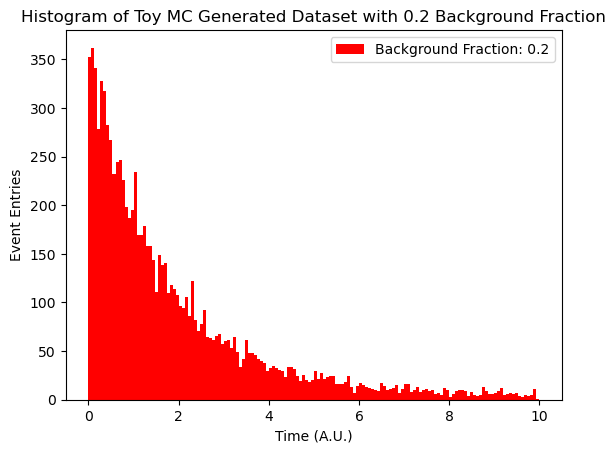

In [26]:
plt.hist(dataset2, 150, color=colors[2],\
         label='Background Fraction: %s' % bkgFraction_vals[2], range=(0., 10.))
plt.xlabel('Time (A.U.)')
plt.ylabel('Event Entries')
plt.title('Histogram of Toy MC Generated Dataset with 0.2 Background Fraction')
plt.legend()
plt.show()

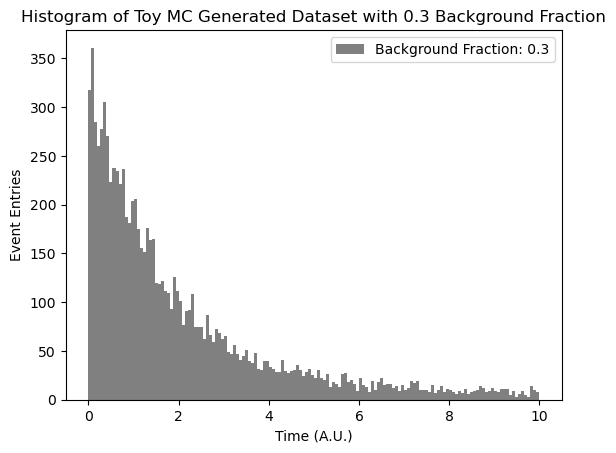

In [27]:
plt.hist(dataset3, 150, color=colors[3],\
         label='Background Fraction: %s' % bkgFraction_vals[3], range=(0., 10.))
plt.xlabel('Time (A.U.)')
plt.ylabel('Event Entries')
plt.title('Histogram of Toy MC Generated Dataset with 0.3 Background Fraction')
plt.legend()
plt.show()

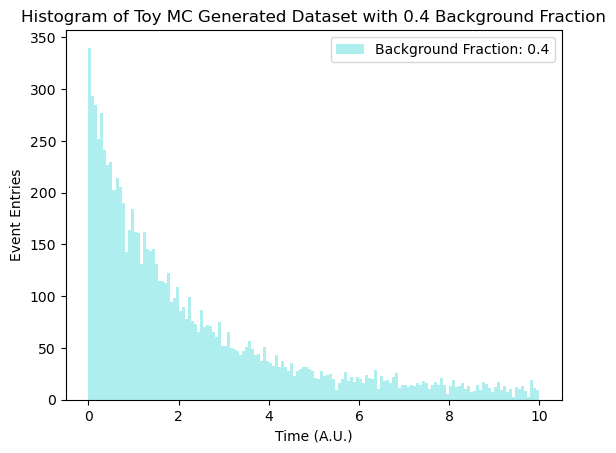

In [28]:
plt.hist(dataset4, 150, color=colors[4],\
         label='Background Fraction: %s' % bkgFraction_vals[4], range=(0., 10.))
plt.xlabel('Time (A.U.)')
plt.ylabel('Event Entries')
plt.title('Histogram of Toy MC Generated Dataset with 0.4 Background Fraction')
plt.legend()
plt.show()

As we can see here, with the increasing background fraction, due to the exponential nature of the background, it suppresses our signal and the initial peak is reduced along the increment.

Next, with these 5 datasets, we will use minuit and negative log-likelyhood minimize statistics to fit the data. And here, we would act like we don't know about the exponential background and fit using only the signal distribution (our pdf described in the description section).

In [29]:
# first define empty disctionaries used to hold optimized params and the errors, as well as a dict with initial params
optimized_params_val_dict = {
    'tau'                :[],
    'delta_m'            :[],
    'V'                  :[],
}

optimized_params_val_err_dict = {
    'tau_err'                :[],
    'delta_m_err'            :[],
    'V_err'                  :[],
}

init_params_dict = {
    'tau'                :1.5,
    'delta_m'            :21.,
    'V'                  :0.06,
}

In [30]:
# Fit our first dataset with background fraction of 0.
# The *list(nominal_params_vals.values())[:-1] is for passing only the first 3 params as we have the decayConst for exponential here as well
pdf0 = DecayPDF(loBound, hiBound, *list(nominal_params_vals.values())[:-1])

# Minimize using Minuit and neg LL minimize statistics
fit_stats0 = NegativeLLcalculator(pdf0, dataset0)
minuit_minimizer0 = Minuit(fit_stats0.evaluate, **init_params_dict)

minuit_minimizer0.errordef = 0.5
mresult = minuit_minimizer0.migrad()

# Store optimized parameter values into the dictionary
optimized_params_val_dict['tau'].append(mresult.values['tau'])
optimized_params_val_dict['delta_m'].append(mresult.values['delta_m'])
optimized_params_val_dict['V'].append(mresult.values['V'])

# Store error values for the optimized parameters into the dictionary
optimized_params_val_err_dict['tau_err'].append(mresult.errors['tau'])
optimized_params_val_err_dict['delta_m_err'].append(mresult.errors['delta_m'])
optimized_params_val_err_dict['V_err'].append(mresult.errors['V'])

In [31]:
# Fit our second dataset with background fraction of 0.1.
# The *list(nominal_params_vals.values())[:-1] is for passing only the first 3 params as we have the decayConst for exponential here as well
pdf1 = DecayPDF(loBound, hiBound, *list(nominal_params_vals.values())[:-1])

# Minimize using Minuit and neg LL minimize statistics
fit_stats1 = NegativeLLcalculator(pdf1, dataset1)
minuit_minimizer1 = Minuit(fit_stats1.evaluate, **init_params_dict)

minuit_minimizer1.errordef = 0.5
mresult = minuit_minimizer1.migrad()

# Store optimized parameter values into the dictionary
optimized_params_val_dict['tau'].append(mresult.values['tau'])
optimized_params_val_dict['delta_m'].append(mresult.values['delta_m'])
optimized_params_val_dict['V'].append(mresult.values['V'])

# Store error values for the optimized parameters into the dictionary
optimized_params_val_err_dict['tau_err'].append(mresult.errors['tau'])
optimized_params_val_err_dict['delta_m_err'].append(mresult.errors['delta_m'])
optimized_params_val_err_dict['V_err'].append(mresult.errors['V'])

In [32]:
# Fit our third dataset with background fraction of 0.2.
# The *list(nominal_params_vals.values())[:-1] is for passing only the first 3 params as we have the decayConst for exponential here as well
pdf2 = DecayPDF(loBound, hiBound, *list(nominal_params_vals.values())[:-1])

# Minimize using Minuit and neg LL minimize statistics
fit_stats2 = NegativeLLcalculator(pdf2, dataset2)
minuit_minimizer2 = Minuit(fit_stats2.evaluate, **init_params_dict)

minuit_minimizer2.errordef = 0.5
mresult = minuit_minimizer2.migrad()

# Store optimized parameter values into the dictionary
optimized_params_val_dict['tau'].append(mresult.values['tau'])
optimized_params_val_dict['delta_m'].append(mresult.values['delta_m'])
optimized_params_val_dict['V'].append(mresult.values['V'])

# Store error values for the optimized parameters into the dictionary
optimized_params_val_err_dict['tau_err'].append(mresult.errors['tau'])
optimized_params_val_err_dict['delta_m_err'].append(mresult.errors['delta_m'])
optimized_params_val_err_dict['V_err'].append(mresult.errors['V'])

In [33]:
# Fit our fourth dataset with background fraction of 0.3.
# The *list(nominal_params_vals.values())[:-1] is for passing only the first 3 params as we have the decayConst for exponential here as well
pdf3 = DecayPDF(loBound, hiBound, *list(nominal_params_vals.values())[:-1])

# Minimize using Minuit and neg LL minimize statistics
fit_stats3 = NegativeLLcalculator(pdf3, dataset3)
minuit_minimizer3 = Minuit(fit_stats3.evaluate, **init_params_dict)

minuit_minimizer3.errordef = 0.5
mresult = minuit_minimizer3.migrad()

# Store optimized parameter values into the dictionary
optimized_params_val_dict['tau'].append(mresult.values['tau'])
optimized_params_val_dict['delta_m'].append(mresult.values['delta_m'])
optimized_params_val_dict['V'].append(mresult.values['V'])

# Store error values for the optimized parameters into the dictionary
optimized_params_val_err_dict['tau_err'].append(mresult.errors['tau'])
optimized_params_val_err_dict['delta_m_err'].append(mresult.errors['delta_m'])
optimized_params_val_err_dict['V_err'].append(mresult.errors['V'])

In [34]:
# Fit our fifth dataset with background fraction of 0.4.
# The *list(nominal_params_vals.values())[:-1] is for passing only the first 3 params as we have the decayConst for exponential here as well
pdf4 = DecayPDF(loBound, hiBound, *list(nominal_params_vals.values())[:-1])

# Minimize using Minuit and negLL minimize statistics
fit_stats4 = NegativeLLcalculator(pdf4, dataset4)
minuit_minimizer4 = Minuit(fit_stats4.evaluate, **init_params_dict)

minuit_minimizer4.errordef = 0.5
mresult = minuit_minimizer4.migrad()

# Store optimized parameter values into the dictionary
optimized_params_val_dict['tau'].append(mresult.values['tau'])
optimized_params_val_dict['delta_m'].append(mresult.values['delta_m'])
optimized_params_val_dict['V'].append(mresult.values['V'])

# Store error values for the optimized parameters into the dictionary
optimized_params_val_err_dict['tau_err'].append(mresult.errors['tau'])
optimized_params_val_err_dict['delta_m_err'].append(mresult.errors['delta_m'])
optimized_params_val_err_dict['V_err'].append(mresult.errors['V'])

Now, with our fitted parameter values and their errors stored, we will now plot the fit alongside with each dataset of changing background fraction. 

In [35]:
# Define colors for each plot
colors = ['blue', 'green', 'red', 'gray', 'paleturquoise']
colors_fit_line = ['red', 'magenta', 'black', 'purple', 'green']

In [36]:
# Set value of parameter for remaining parameters
pdf.setParameters(optimized_params_val_dict['tau'][0], optimized_params_val_dict['delta_m'][0],\
                  optimized_params_val_dict['V'][0])

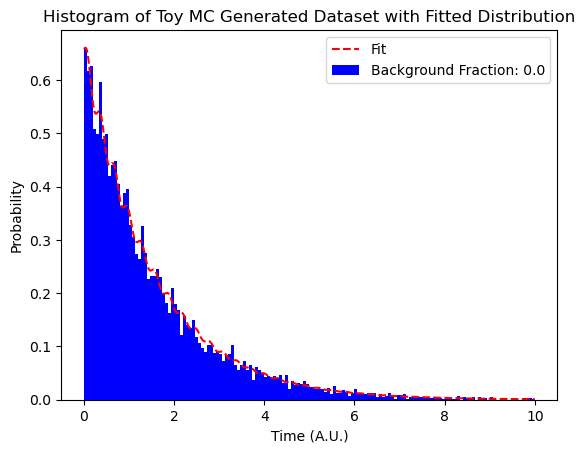

In [37]:
plt.plot(t, pdf.evaluate(t)/pdf.integrate(loBound, hiBound), color=colors_fit_line[0], \
         label='Fit', ls='--')
plt.hist(dataset0, 150, color=colors[0], density=True,\
         label='Background Fraction: %s' % bkgFraction_vals[0], range=(0.0, 10.0))
plt.xlabel('Time (A.U.)')
plt.ylabel('Probability')
plt.title('Histogram of Toy MC Generated Dataset with Fitted Distribution')
plt.legend()
plt.show()

In [38]:
# Set value of parameter for remaining parameters
pdf.setParameters(optimized_params_val_dict['tau'][1], optimized_params_val_dict['delta_m'][1],\
                  optimized_params_val_dict['V'][1])

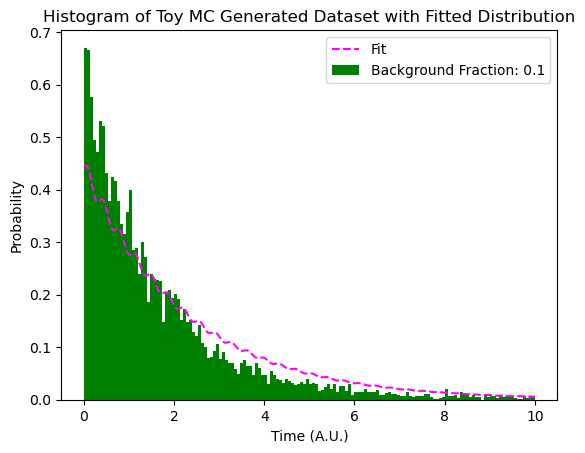

In [39]:
plt.plot(t, pdf.evaluate(t)/pdf.integrate(loBound, hiBound), color=colors_fit_line[1], \
         label='Fit', ls='--')
plt.hist(dataset1, 150, color=colors[1], density=True,\
         label='Background Fraction: %s' % bkgFraction_vals[1], range=(0.0, 10.0))
plt.xlabel('Time (A.U.)')
plt.ylabel('Probability')
plt.title('Histogram of Toy MC Generated Dataset with Fitted Distribution')
plt.legend()
plt.show()

In [40]:
# Set value of parameter for remaining parameters
pdf.setParameters(optimized_params_val_dict['tau'][2], optimized_params_val_dict['delta_m'][2],\
                  optimized_params_val_dict['V'][2])

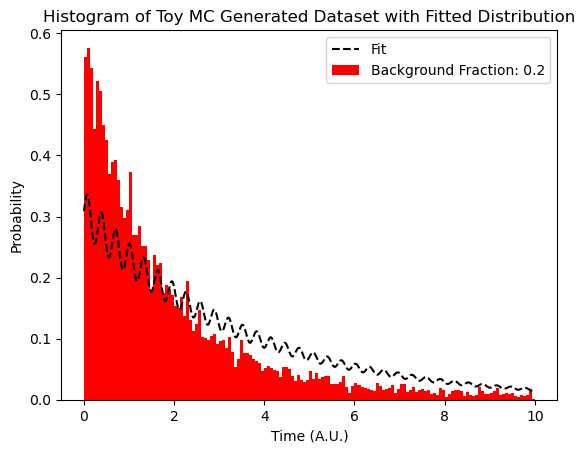

In [41]:
plt.plot(t, pdf.evaluate(t)/pdf.integrate(loBound, hiBound), color=colors_fit_line[2], \
         label='Fit', ls='--')
plt.hist(dataset2, 150, color=colors[2], density=True,\
         label='Background Fraction: %s' % bkgFraction_vals[2], range=(0.0, 10.0))
plt.xlabel('Time (A.U.)')
plt.ylabel('Probability')
plt.title('Histogram of Toy MC Generated Dataset with Fitted Distribution')
plt.legend()
plt.show()

In [42]:
# Set value of parameter for remaining parameters
pdf.setParameters(optimized_params_val_dict['tau'][3], optimized_params_val_dict['delta_m'][3],\
                  optimized_params_val_dict['V'][3])

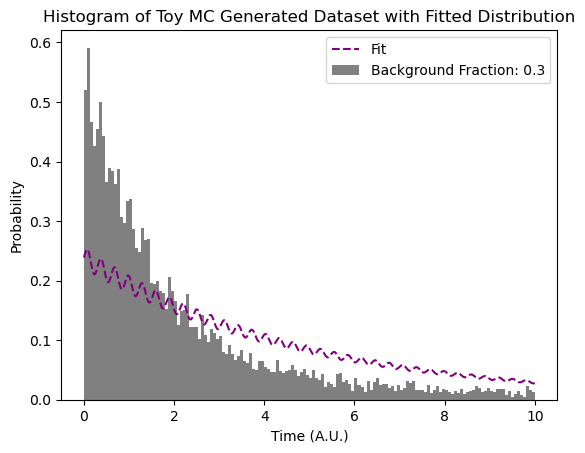

In [43]:
plt.plot(t, pdf.evaluate(t)/pdf.integrate(loBound, hiBound), color=colors_fit_line[3], \
         label='Fit', ls='--')
plt.hist(dataset3, 150, color=colors[3], density=True,\
         label='Background Fraction: %s' % bkgFraction_vals[3], range=(0.0, 10.0))
plt.xlabel('Time (A.U.)')
plt.ylabel('Probability')
plt.title('Histogram of Toy MC Generated Dataset with Fitted Distribution')
plt.legend()
plt.show()

In [44]:
# Set value of parameter for remaining parameters
pdf.setParameters(optimized_params_val_dict['tau'][4], optimized_params_val_dict['delta_m'][4],\
                  optimized_params_val_dict['V'][4])

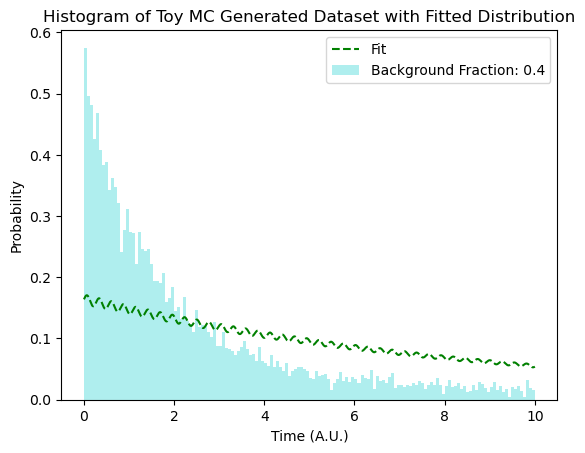

In [45]:
plt.plot(t, pdf.evaluate(t)/pdf.integrate(loBound, hiBound), color=colors_fit_line[4], \
         label='Fit', ls='--')
plt.hist(dataset4, 150, color=colors[4], density=True,\
         label='Background Fraction: %s' % bkgFraction_vals[4], range=(0.0, 10.0))
plt.xlabel('Time (A.U.)')
plt.ylabel('Probability')
plt.title('Histogram of Toy MC Generated Dataset with Fitted Distribution')
plt.legend()
plt.show()

Next, let's create plots showing how the fitted value of each parameter $\tau$, $\Delta m$ and $V$ varies as a function of the background fraction. Lines of nominal value for these parameters are plotted as well.

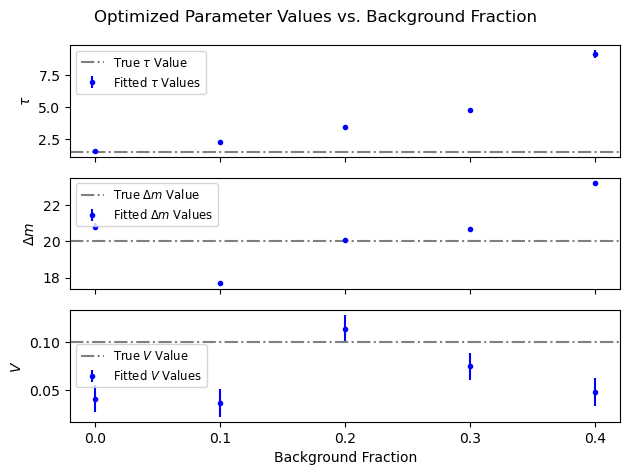

In [46]:
# Define config parameters for the plot
fig, ax = plt.subplots(len(optimized_params_val_dict.keys()), 1, sharex=True)
ax[-1].set_xlabel(r'Background Fraction')

# plot for the tau parameter
ax[0].errorbar(bkgFraction_vals, optimized_params_val_dict['tau'], yerr=optimized_params_val_err_dict['tau_err'],\
               fmt='b.', label=r'Fitted $\tau$ Values')
ax[0].axhline(nominal_params_vals['tau'], 0., 1., ls='-.', color='gray', label=r'True $\tau$ Value')
ax[0].set_xticks(bkgFraction_vals)
ax[0].set_ylabel(r'$\tau$')
ax[0].legend(fontsize='small')

# plot for the delta M parameter
ax[1].errorbar(bkgFraction_vals, optimized_params_val_dict['delta_m'], yerr=optimized_params_val_err_dict['delta_m_err'],\
               fmt='b.', label=r'Fitted $\Delta m$ Values')
ax[1].axhline(nominal_params_vals['delta_m'], 0., 1., ls='-.', color='gray', label=r'True $\Delta m$ Value')
ax[1].set_xticks(bkgFraction_vals)
ax[1].set_ylabel(r'$\Delta m$')
ax[1].legend(fontsize='small')

# plot for the V parameter
ax[2].errorbar(bkgFraction_vals, optimized_params_val_dict['V'], yerr=optimized_params_val_err_dict['V_err'],\
               fmt='b.', label=r'Fitted $V$ Values')
ax[2].axhline(nominal_params_vals['V'], 0., 1., ls='-.', color='gray', label=r'True $V$ Value')
ax[2].set_xticks(bkgFraction_vals)
ax[2].set_ylabel(r'$V$')
ax[2].legend(fontsize='small')

fig.suptitle('Optimized Parameter Values vs. Background Fraction')
fig.tight_layout()


With us now plotting up the fitted parameter values with respective to the background fractions (with the dashline in plots showing the nominal/truth value for that parameter), we can see that $\Delta m$ and $V$ are largely uncorrelated with us applying the particle decay pdf distribution fit onto datasets containing the particle decay pdf distribution fit with exponential background for low background fraction values. Resulting in the bias of the optimized $\Delta m$ and $V$ parameters remaining primarily unchanged.

At the same time, looking at the $\tau$ parameter, or the time constant of the exponential decay term in our PDF describing the particle decay from $X \rightarrow D$, we can see that the parameters is very strongly correlated with the background fraction as the $\tau$ parameter diverges away from the nominal/truth parameter value with increasing background fraction.

This correlation behavior with the $\tau$ and the background fraction is to be expected as increasing the background fraction (our exponential background) will interfere with our PDF distribution and smear it into an exponential decay with longer lifetime, which our optimizer finds that a larger value for the $\tau$ parameter will minimize the negative log-likelyhood better as it attempts to fit the smeared distribution.

In conclusion, from this, we see that with the increasing background fraction, the bias on our optimized $\tau$ fit parameter will also increase.